In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable 
from Model_train import ulti
torch.cuda.is_available()

True

In [19]:
from Data_train import epoch 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
import numpy as np

# X, Y = create_epoch()




# with open("Data_train/Saved/arrayX.txt", "a") as arrayX:
#           np.savetxt(arrayX, X, delimiter=",", fmt='%.4f')

# with open("Data_train/Saved/arrayY.txt", "a") as arrayY:
#           np.savetxt(arrayY, Y, delimiter=",", fmt='%.4f')


In [20]:
# torch.set_default_tensor_type('torch.cuda.FloatTensor')


In [21]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length


        self.batchnorm1 = nn.BatchNorm1d(input_size, affine = True)

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1

        self.batchnorm2 = nn.BatchNorm1d(128, affine = True)

        self.relu = nn.ReLU()

        self.fc = nn.Linear(128, num_classes) #fully connected last layer
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        x = torch.transpose(x, 1, 2)
        x = self.batchnorm1(x)
        x = torch.transpose(x, 1, 2)

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.batchnorm2(out)
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [22]:
batchnorm1 = nn.BatchNorm1d(4, affine=False)
input = torch.tensor([[1,1,1,1], [2,2,1,1], [1,1,3,3]], dtype = torch.float32)
input = batchnorm1(input)
input

tensor([[-0.7071, -0.7071, -0.7071, -0.7071],
        [ 1.4142,  1.4142, -0.7071, -0.7071],
        [-0.7071, -0.7071,  1.4142,  1.4142]])

In [23]:
lstm = LSTM(num_classes = 7, input_size = 3,
                    hidden_size = 3, num_layers = 1, seq_length = 30)

In [24]:
X = np.loadtxt("/home/it/Desktop/NTMINH/Data/Data/data_train/arrayX_train_30_30_30_7_days_pred_7_days_2020.txt", delimiter=",")
Y = np.loadtxt("/home/it/Desktop/NTMINH/Data/Data/data_train/arrayY_train_30_30_30_7_days_pred_7_days_2020.txt", delimiter=",")

In [25]:
# Giữ lại một số sku để test
sku_test = 103
sku_val = 100
sku_train = round(X.shape[0]/329.0 - sku_test - sku_val)

day_temp = 329


# split data into train and test sets
seed = 7
test_size = 0.2
X_train, y_train= X[:sku_train*day_temp], Y[:sku_train*day_temp]
X_val, y_val = X[sku_train*day_temp:(sku_train + sku_val)*day_temp], Y[sku_train*day_temp:(sku_train + sku_val)*day_temp]
X_test, y_test = X[(sku_train + sku_val)*day_temp:], Y[(sku_train + sku_val)*day_temp:]

X_train = X_train[:, :90]
X_val = X_val[:, :90]
X_test = X_test[:, :90]
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(230300, 90)
(32900, 90)
(33887, 90)
(230300, 7)
(32900, 7)
(33887, 7)


In [26]:
# Chuẩn bị data dể train và test
# X_train_tensors = Variable(torch.Tensor(X_train.reshape(-1,3,30).transpose(0,2,1)))
# X_val_tensors = Variable(torch.Tensor(X_val.reshape(-1,3,30).transpose(0,2,1)))
# X_test_tensors = Variable(torch.Tensor(X_test.reshape(-1,3,30).transpose(0,2,1)))

X_train_tensors = Variable(torch.Tensor(X_train.reshape(-1,3,30)))
X_val_tensors = Variable(torch.Tensor(X_val.reshape(-1,3,30)))
X_test_tensors = Variable(torch.Tensor(X_test.reshape(-1,3,30)))

y_train_tensors = Variable(torch.Tensor(y_train))
y_val_tensors = Variable(torch.Tensor(y_val))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [27]:
X_train_tensors = X_train_tensors.cuda()

In [28]:
X_val_tensors.shape

torch.Size([32900, 3, 30])

In [29]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 30 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 7 #number of output classes 

batch_size = 128

In [30]:
lstm = LSTM(num_classes = num_classes, input_size = input_size,
                    hidden_size = hidden_size, num_layers = num_layers, seq_length = 30)

In [31]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

In [32]:
# for epoch in range(num_epochs):

#           # X is a torch Variable
#           permutation = torch.randperm(X_train_tensors.size()[0])

#           for i in range(0,X_train_tensors.size()[0], batch_size):
#                     optimizer.zero_grad()         #caluclate the gradient, manually setting to 0

#                     indices = permutation[i:i+batch_size]
#                     batch_x, batch_y = X_train_tensors[indices], y_train_tensors[indices]

#                     # in case you wanted a semi-full example
#                     outputs = lstm.forward(batch_x)
#                     loss = criterion(outputs,batch_y)

#                     loss.backward() #calculates the loss of the loss function
#                     optimizer.step() #improve from loss, i.e backprop


#           loss_val = 0
#           with torch.no_grad():
#                     outputs_val = lstm.forward(X_val_tensors)
#                     loss_val = criterion(outputs_val, X_val_tensors)

#           print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
#           print("Epoch: %d, loss_val: %1.5f" % (epoch, loss_val.item())) 
#           ulti.save_checkpoint(lstm, optimizer, 
#                     f'../../Data/Data/model_train/lstm_30_30_30_pred_7_epoch_{epoch}', epoch=epoch)

In [33]:
ulti.load_checkpoint(lstm, optimizer, '/home/it/Desktop/NTMINH/Data/Data/model_train/lstm_transpose_batchnorm_30_30_30_hidden_128_pred_7_epoch_999')

(LSTM(
   (batchnorm1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (lstm): LSTM(30, 128, batch_first=True)
   (fc_1): Linear(in_features=128, out_features=128, bias=True)
   (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
   (fc): Linear(in_features=128, out_features=7, bias=True)
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     eps: 1e-08
     foreach: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 999)

In [34]:
model = lstm
y_pred = model.forward(X_test_tensors).detach().numpy()

RuntimeError: CUDA out of memory. Tried to allocate 498.00 MiB (GPU 0; 1.95 GiB total capacity; 320.77 MiB already allocated; 215.06 MiB free; 774.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
np.sqrt(np.square(np.subtract(y_test, y_pred))).sum()/y_test.shape[0]

9.32632666265102

In [ ]:
y_pred_int = np.asarray(y_pred, dtype = np.int32)
y_pred_int[y_pred_int < 0] = 0

In [ ]:

print('Số lượng lable > 0',len(y_test[y_test > 0]))
print('Số lượng lable == 0',len(y_test[y_test == 0]))

print('Số lượng pred > 0',len(y_pred_int[y_pred_int > 0]))
print('Số lượng pred == 0',len(y_pred_int[y_pred_int == 0]))
print('Số lượng pred == 0',len(y_pred_int[y_pred_int < 0]))

Số lượng lable > 0 113675
Số lượng lable == 0 123534
Số lượng pred > 0 108806
Số lượng pred == 0 128403
Số lượng pred == 0 0


In [ ]:
# Tỉ lệ khi label = 0 và dự đoán đoán đúng

total = len(y_test[y_test == 0])
acc = np.sum((y_test == 0) & (y_pred_int == 0))
acc/total

0.7521330160117863

In [ ]:
# Tỉ lệ đoán khác 0 khi dữ liệu thật khác 0

total = len(y_test[y_test != 0])
acc = ((y_test != 0) & (y_pred_int != 0)).sum()
acc/total

0.6878029469980207

In [ ]:
condition = np.where(y_test != 0)
np.sqrt(np.square(np.subtract(y_test[condition], y_pred[condition]))).sum()/y_test.shape[0]

6.449110672262406

In [ ]:
print(np.max(np.subtract(y_test[condition], y_pred[condition])))
print(np.min(np.subtract(y_test[condition], y_pred[condition])))

225.05635404586792
-51.298377990722656


<AxesSubplot:>

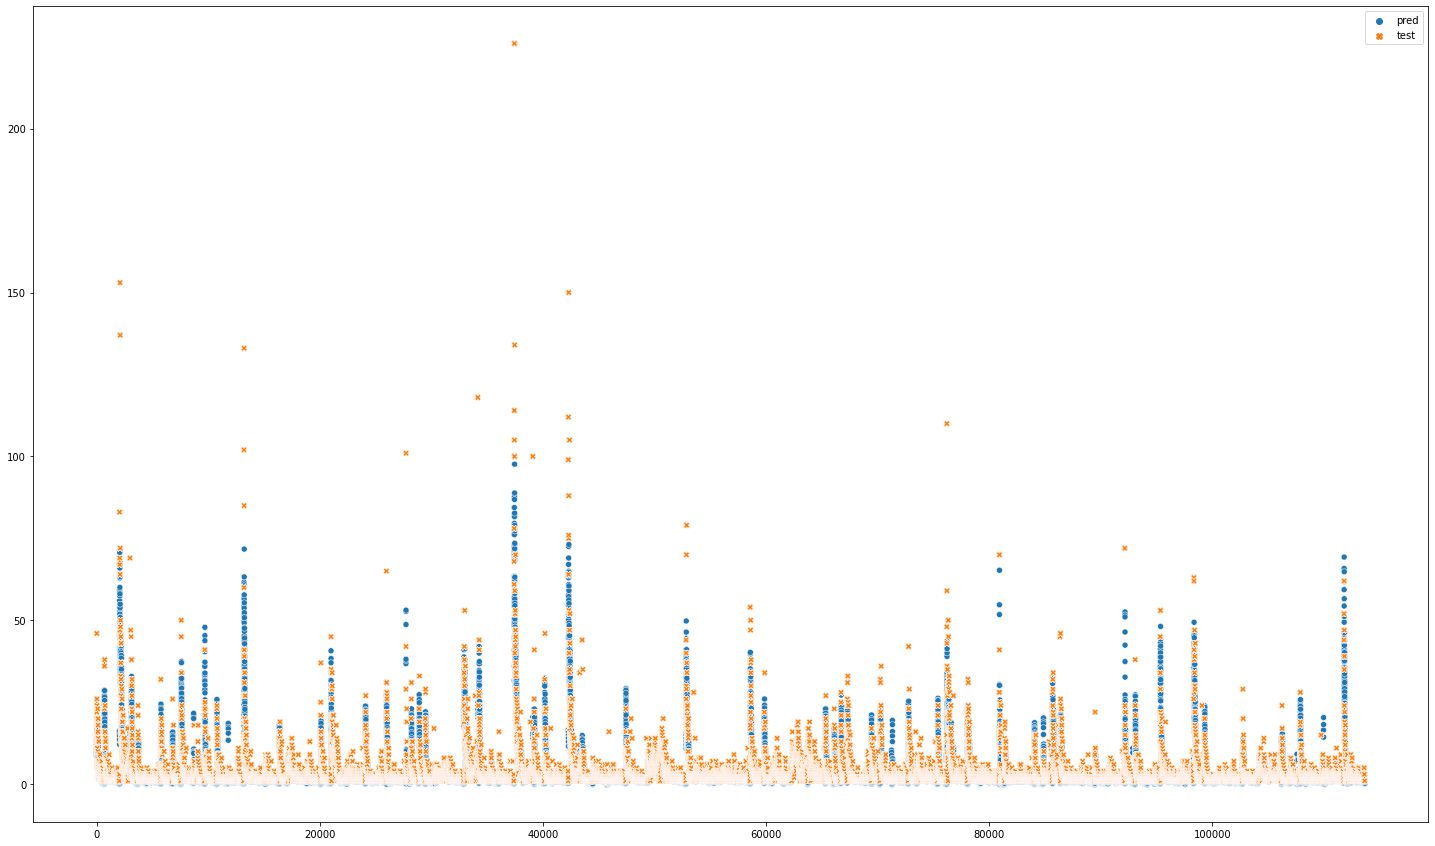

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
condition = np.where(y_test != 0)

df = pd.DataFrame({ 'pred': y_pred[condition],
                    'test':  y_test[condition]})

fig, ax = plt.subplots(figsize = (25, 15))
sns.scatterplot(data = df, ax = ax)

In [ ]:
X_test.shape[0]/103

329.0

In [ ]:
round(np.random.rand()*100)

46

In [ ]:
num = round(np.random.rand()*100)


temp = X_test[day_temp*num + 50:60 + day_temp*num, :17].copy()
print(temp)

temp = y_test[day_temp*num + 50:60 + day_temp*num].copy()
print(temp)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[ 0.  0. 20. 17. 18. 28. 29.]
 [ 0. 20. 17. 18. 28. 29. 14.]
 [20. 17. 18. 28. 29. 14. 15.]
 [17. 18. 28. 29. 14. 15. 10.]
 [18. 28. 29. 14. 15. 10.  5.]
 [28. 29. 14. 15. 10.  5.  7.]
 [29. 14. 15. 10.  5.  7.  4.]
 [14. 15. 10.  5.  7.  4.  4.]
 [15. 10.  5.  7.  4.  4.  2.]
 [10.  5.  7.  4.  4.  2.  3.]]


In [ ]:
temp = X_test[day_temp*num:day_temp + day_temp*num].copy()
temp.shape

(329, 90)

<AxesSubplot:>

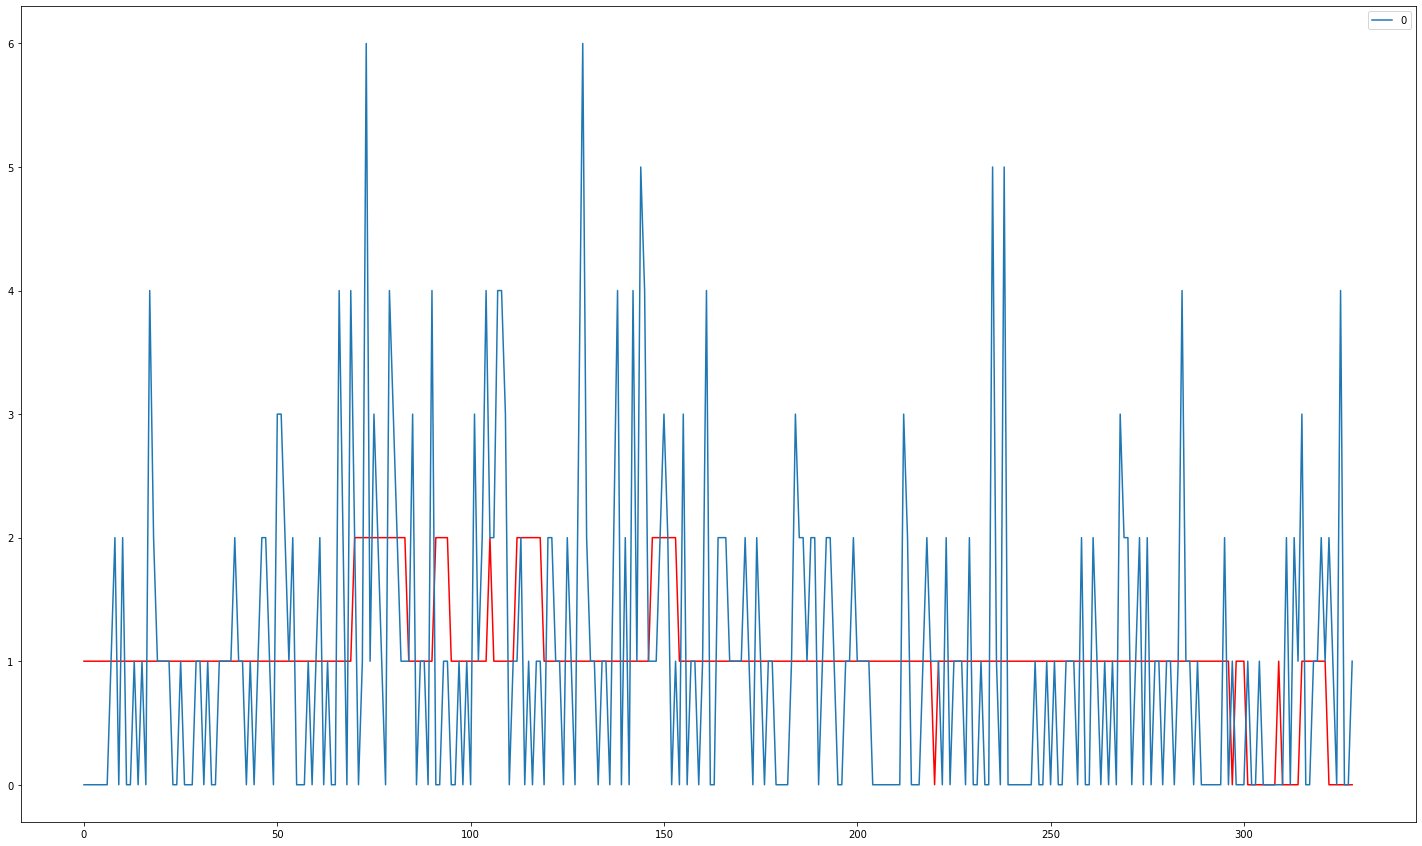

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'test':  np.random.rand(5)})
df2 = pd.DataFrame({'test':  np.random.rand(5)})

num = round(np.random.rand()*100)

temp = X_test_tensors[day_temp*num:day_temp + day_temp*num]
result = y_test_tensors[day_temp*num:day_temp + day_temp*num, 0:1]
# result = np.zeros(shape = (day_temp, day_temp))
temp.shape

fig, ax = plt.subplots(figsize = (25, 15))

array = np.zeros(shape = (day_temp, day_temp))
array[:] = np.nan

predict_list = model.forward(temp).detach().numpy()

for i in range(0, day_temp - 7, 7):
          predict = predict_list[i]

          array[i, i:i+7] = np.round(predict)
          # result[i, i:i+7] = y_test[day_temp*num + i]


array = np.nan_to_num(array)
array = np.sum(array, axis = 0)

sns.lineplot(data = array, ax = ax, color = 'red')

# result = np.nan_to_num(result)
# result = np.sum(result, axis = 0)
# for row in range(array.shape[0]):
#           sns.lineplot(data = array[row], ax = ax)

sns.lineplot(data = result, ax = ax)

<AxesSubplot:>

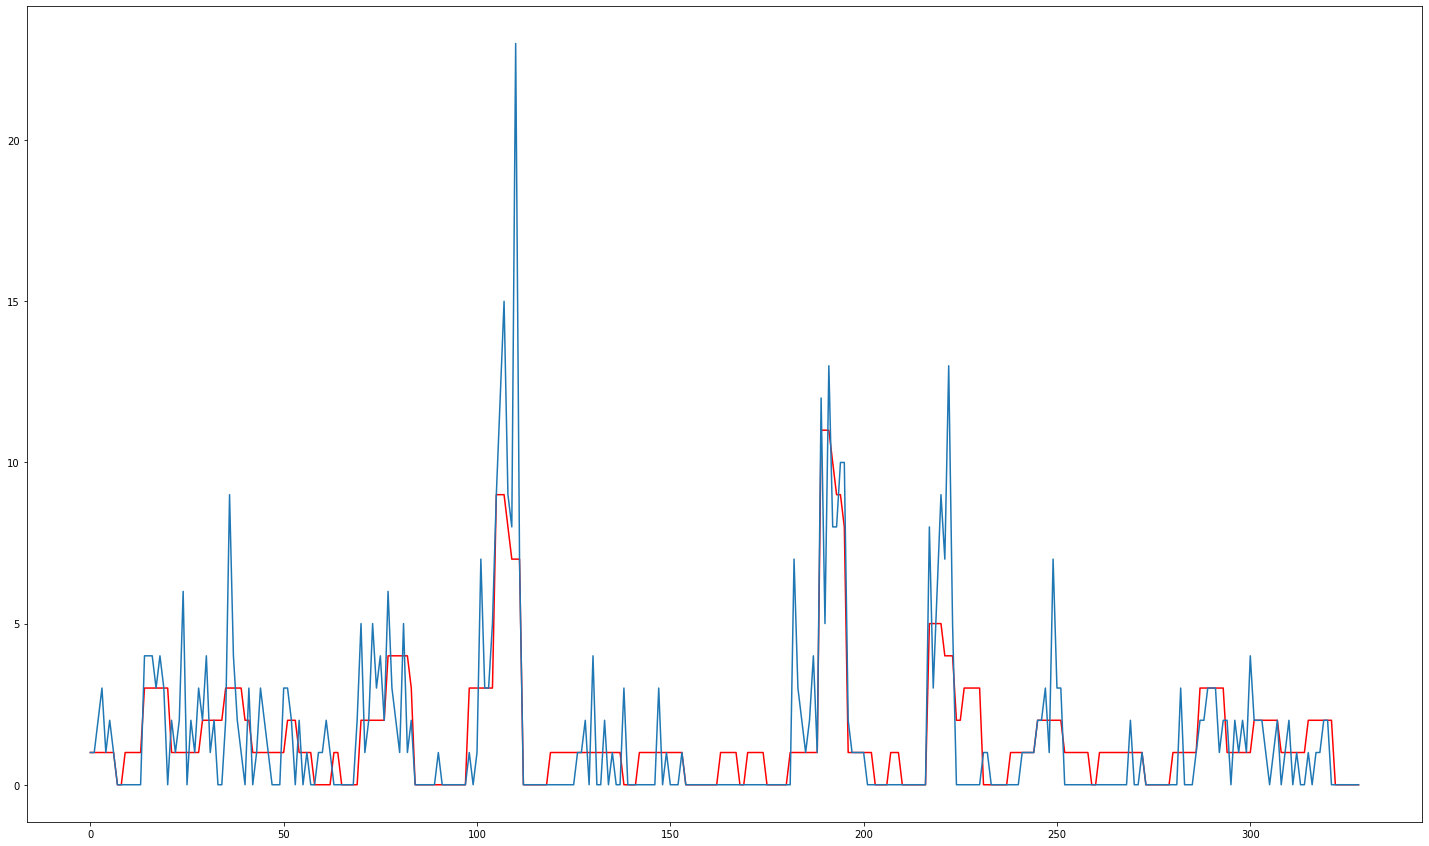

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'test':  np.random.rand(5)})
df2 = pd.DataFrame({'test':  np.random.rand(5)})

num = round(np.random.rand()*100)

# temp = X_test[day_temp*num:day_temp + day_temp*num].copy()
# result = y_test[day_temp*num:day_temp + day_temp*num, 6:7].copy()

fig, ax = plt.subplots(figsize = (25, 15))

array = np.zeros(shape = (day_temp, day_temp))
result = np.zeros(shape = (day_temp, day_temp))
array[:] = np.nan
result[:] = np.nan

for i in range(0, day_temp - 7, 7):
          num = round(np.random.rand()*33887)
          temp = X_test_tensors[num: num+1]
          predict = model.forward(temp).detach().numpy()

          array[i, i:i+7] = np.round(predict)
          result[i, i:i+7] = y_test[num]

array = np.nan_to_num(array)
array = np.sum(array, axis = 0)

result = np.nan_to_num(result)
result = np.sum(result, axis = 0)

sns.lineplot(data = array, ax = ax, color = 'red')

# for row in range(array.shape[0]):
#           sns.lineplot(data = array[row], ax = ax)

sns.lineplot(data = result, ax = ax)

In [ ]:
# Sử dụng độ đo MSE trên mỗi ngày
# make predictions for test data

error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred, y_test))))/(y_pred.shape[0]*y_pred.shape[1])
print('Lỗi trên mỗi ngày: ',error_per_day)

Lỗi trên mỗi ngày:  1.3323323803787173


In [ ]:
# Sử dụng độ đo MSE trên mỗi tuần
# make predictions for test data


error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred, y_test))))/(y_pred.shape[0])
print('Lỗi trên mỗi tuần: ',error_per_day)

Lỗi trên mỗi tuần:  9.32632666265102


In [ ]:
y_pred_int = np.asarray(y_pred, dtype = np.int32)
y_pred_int[y_pred_int < 0] = 0

# phần trăm dự đoán đúng những ngày không bán
total = np.sum(y_test == 0)

right = np.sum((y_test == 0) & (y_pred_int == 0))

print('Phần trăm dự đoán đúng những ngày không bán:', right/total)

Phần trăm dự đoán đúng những ngày không bán: 0.7521330160117863


In [ ]:
y_test_0 = y_test[y_test == 0]
y_pred_of_test_0 = y_pred[y_test == 0]

error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred_of_test_0, y_test_0))))/(y_pred.shape[0])
print('Lỗi trên mỗi tuần: ',error_per_day)

error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred_of_test_0, y_test_0))))/(y_pred.shape[0]*y_pred.shape[1])
print('Lỗi trên mỗi ngày: ',error_per_day)

Lỗi trên mỗi tuần:  2.8772159903886148
Lỗi trên mỗi ngày:  0.41103085576980214


In [ ]:
print(np.sum(np.subtract(y_pred_of_test_0, y_test_0) > 70))
print(np.sum(np.subtract(y_pred_of_test_0, y_test_0) > 60))
print(np.sum(np.subtract(y_pred_of_test_0, y_test_0) > 50))
print(np.sum(np.subtract(y_pred_of_test_0, y_test_0) > 40))
print(np.sum(np.subtract(y_pred_of_test_0, y_test_0) > 30))

0
1
4
17
34


In [ ]:
# phần trăm dự đoán đúng những ngày có bán
total = np.sum(y_test != 0)

right = np.sum((y_test != 0) & (y_pred_int != 0))

print('Phần trăm dự đoán đúng những ngày có bán:', right/total)

Phần trăm dự đoán đúng những ngày có bán: 0.6878029469980207


In [ ]:
y_test_not0 = y_test[y_test != 0]
y_pred_of_test_not0 = y_pred[y_test != 0]

error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred_of_test_not0, y_test_not0))))/(y_pred.shape[0])
print('Lỗi trên mỗi tuần: ',error_per_day)

error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred_of_test_not0, y_test_not0))))/(y_pred.shape[0]*y_pred.shape[1])
print('Lỗi trên mỗi ngày: ',error_per_day)

Lỗi trên mỗi tuần:  6.449110672262406
Lỗi trên mỗi ngày:  0.9213015246089151


In [ ]:
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 100))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 90))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 80))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 70))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 60))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 50))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 40))
print(np.sum(np.abs(np.subtract(y_pred_of_test_not0, y_test_not0)) > 30))

46
72
90
113
177
216
314
495


In [ ]:
def behon(a1, a2, threshold):
          a = np.subtract(a1, a2)
          b = np.abs(a[a < 0]) > threshold
          return b.sum()

def lonhon(a1, a2, threshold):
          a = np.subtract(a1, a2)
          b = np.abs(a[a > 0]) > threshold
          return b.sum()

In [ ]:
print(behon(y_pred_of_test_not0, y_test_not0,100))
print(behon(y_pred_of_test_not0, y_test_not0,90))
print(behon(y_pred_of_test_not0, y_test_not0,80))
print(behon(y_pred_of_test_not0, y_test_not0,70))
print(behon(y_pred_of_test_not0, y_test_not0,60))
print(behon(y_pred_of_test_not0, y_test_not0,50))
print(behon(y_pred_of_test_not0, y_test_not0,40))
print(behon(y_pred_of_test_not0, y_test_not0,30))

46
72
90
113
177
215
311
476


In [ ]:
print(lonhon(y_pred_of_test_not0, y_test_not0,100))
print(lonhon(y_pred_of_test_not0, y_test_not0,90))
print(lonhon(y_pred_of_test_not0, y_test_not0,80))
print(lonhon(y_pred_of_test_not0, y_test_not0,70))
print(lonhon(y_pred_of_test_not0, y_test_not0,60))
print(lonhon(y_pred_of_test_not0, y_test_not0,50))
print(lonhon(y_pred_of_test_not0, y_test_not0,40))
print(lonhon(y_pred_of_test_not0, y_test_not0,30))

0
0
0
0
0
1
3
19


In [ ]:
def tracking_signal(y_test, y_pred):
          temp1 = np.multiply(np.sum(np.subtract(y_test, y_pred), axis=1), 7)
          temp2 = np.sum(np.abs(np.subtract(y_test, y_pred)), axis = 1)

          result = np.divide(temp1, temp2)
          return result
          pass

sum_int_pred = np.sum(y_pred_int, axis = 1)
sum_int_test = np.sum(y_test, axis = 1)
sum_int_error = np.sum(np.sqrt(np.square(np.subtract(y_pred_int, y_test))), axis = 1)
sum_error = np.sum(np.sqrt(np.square(np.subtract(y_pred, y_test))), axis = 1)
sum_int_error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred_int, y_test))), axis = 1)/7
sum_error_per_day = np.sum(np.sqrt(np.square(np.subtract(y_pred, y_test))), axis = 1)/7
sum_error_boolean = np.sum(y_test == y_pred_int, axis = 1)/7
sum_error_sum  = np.abs(np.subtract(sum_int_pred, sum_int_test))
sum_error_tracking_signal = tracking_signal(y_test, y_pred)

In [ ]:
# Xác định tăng giảm của đơn hàng trong ngày
y_test_6_day = y_test[:, :6].copy()
x_test_1_day = X_test[:, 29:30].copy()
pre_7_day = np.concatenate((x_test_1_day, y_test_6_day), axis = 1)
pre_7_day.shape

is_higher = y_test >= pre_7_day
is_higher_predict = y_pred_int >= pre_7_day
is_lower = y_test <= pre_7_day
is_lower_predict = y_pred_int <= pre_7_day


sum_acc_higher, soluonghigher = np.sum(is_higher_predict & is_higher, axis = 1), np.sum(is_higher, axis = 1)
sum_acc_lower, soluonglower = np.sum(is_lower_predict & is_lower, axis = 1), np.sum(is_lower, axis = 1)


# Dự đoán bán và không bán
def khongban(a, b):
          temp1 = a == 0
          temp2 = b == 0

          return np.sum(temp1 & temp2, axis = 1), np.sum(temp1, axis = 1), np.sum(temp2, axis = 1)


def coban(a, b):
          temp1 = (a != 0)
          temp2 = (b != 0)

          return np.sum(temp1 & temp2, axis = 1), np.sum(temp1, axis = 1), np.sum(temp2, axis = 1)

doandungkhongban, soluogkhongban_model, soluogkhongban_pred = khongban(y_test, y_pred_int)
doandungcoban, soluogcoban_model, soluogcoban_pred = coban(y_test, y_pred_int)


In [ ]:
threshold = 50
condition = sum_int_test > threshold
print(f'Có {len(sum_int_test[condition])} sản phẩm thỏa điều kiện > {threshold}')
print(f'Độ lỗi sum_int_error trung bình ở {threshold} là:',sum_int_error[condition].mean())
print(f'Độ lỗi sum_error trung bình ở {threshold} là:',sum_error[condition].mean())
print(f'Độ lỗi sum_int_error_per_day trung bình ở {threshold} là:',sum_int_error_per_day[condition].mean())
print(f'Độ lỗi sum_error_per_day trung bình ở {threshold} là:',sum_error_per_day[condition].mean())
print(f'Độ lỗi sum_error_tracking_signal trung bình ở {threshold} là:',sum_error_tracking_signal[condition].mean())
# print(f'Độ lỗi sum_error_boolean trung bình ở {threshold} là:',sum_error_boolean[condition].mean())
print(f'Độ lỗi sum_error_sum trung bình ở {threshold} là:',sum_error_sum[condition].mean())
print(f'Độ lỗi sum_acc_higher trung bình ở {threshold} là:',sum_acc_higher[condition].sum()/soluonghigher[condition].sum())
print(f'Độ lỗi sum_acc_lower trung bình ở {threshold} là:',sum_acc_lower[condition].sum()/soluonglower[condition].sum())
print(f'Đoán đúng (precision) không bán trung bình ở {threshold} là:',doandungkhongban[condition].sum()/soluogkhongban_pred[condition].sum())
print(f'Đoán đúng (recall) không bán trung bình ở {threshold} là:',doandungkhongban[condition].sum()/soluogkhongban_model[condition].sum())
print(f'Đoán đúng (precision) có bán trung bình ở {threshold} là:',doandungcoban[condition].sum()/soluogcoban_pred[condition].sum())
print(f'Đoán đúng (recall) có bán trung bình ở {threshold} là:',doandungcoban[condition].sum()/soluogcoban_model[condition].sum())

Có 1622 sản phẩm thỏa điều kiện > 50
Độ lỗi sum_int_error trung bình ở 50 là: 58.888409371146736
Độ lỗi sum_error trung bình ở 50 là: 58.38508504768087
Độ lỗi sum_int_error_per_day trung bình ở 50 là: 8.412629910163819
Độ lỗi sum_error_per_day trung bình ở 50 là: 8.340726435382981
Độ lỗi sum_error_tracking_signal trung bình ở 50 là: 2.102027949232913
Độ lỗi sum_error_sum trung bình ở 50 là: 47.010480887792845
Độ lỗi sum_acc_higher trung bình ở 50 là: 0.6071545782737119
Độ lỗi sum_acc_lower trung bình ở 50 là: 0.7787638175307489
Đoán đúng (precision) không bán trung bình ở 50 là: 0.38469284994964753
Đoán đúng (recall) không bán trung bình ở 50 là: 0.6761061946902654
Đoán đúng (precision) có bán trung bình ở 50 là: 0.9823376121995946
Đoán đúng (recall) có bán trung bình ở 50 là: 0.9433682454351654


In [ ]:
threshold = 0
condition = sum_int_test >= threshold
print(f'Có {len(sum_int_test[condition])} sản phẩm thỏa điều kiện >= {threshold}')
print(f'Độ lỗi sum_int_error trung bình ở {threshold} là:',sum_int_error[condition].mean())
print(f'Độ lỗi sum_error trung bình ở {threshold} là:',sum_error[condition].mean())
print(f'Độ lỗi sum_int_error_per_day trung bình ở {threshold} là:',sum_int_error_per_day[condition].mean())
print(f'Độ lỗi sum_error_per_day trung bình ở {threshold} là:',sum_error_per_day[condition].mean())
print(f'Độ lỗi sum_error_tracking_signal trung bình ở {threshold} là:',sum_error_tracking_signal[condition].mean())
# print(f'Độ lỗi sum_error_boolean trung bình ở {threshold} là:',sum_error_boolean[condition].mean())
print(f'Độ lỗi sum_error_sum trung bình ở {threshold} là:',sum_error_sum[condition].mean())
print(f'Độ lỗi sum_acc_higher trung bình ở {threshold} là:',sum_acc_higher[condition].sum()/soluonghigher.sum())
print(f'Độ lỗi sum_acc_lower trung bình ở {threshold} là:',sum_acc_lower[condition].sum()/soluonglower.sum())
print(f'Đoán đúng (precision) không bán trung bình ở {threshold} là:',doandungkhongban[condition].sum()/soluogkhongban_pred[condition].sum())
print(f'Đoán đúng (recall) không bán trung bình ở {threshold} là:',doandungkhongban[condition].sum()/soluogkhongban_model[condition].sum())
print(f'Đoán đúng (precision) có bán trung bình ở {threshold} là:',doandungcoban[condition].sum()/soluogcoban_pred[condition].sum())
print(f'Đoán đúng (recall) có bán trung bình ở {threshold} là:',doandungcoban[condition].sum()/soluogcoban_model[condition].sum())

# Với những ngày bán lớn hơn một lượng hàng thì chênh lệch là bao nhiêu
# Làm một độ đo xem là nhựng cực trí cực đại cực tiểu trong khỏang 3 ngày của predict có trùng với test hay không.


Có 33887 sản phẩm thỏa điều kiện >= 0
Độ lỗi sum_int_error trung bình ở 0 là: 8.596866054829286
Độ lỗi sum_error trung bình ở 0 là: 9.32632666265102
Độ lỗi sum_int_error_per_day trung bình ở 0 là: 1.2281237221184693
Độ lỗi sum_error_per_day trung bình ở 0 là: 1.332332380378717
Độ lỗi sum_error_tracking_signal trung bình ở 0 là: -1.6863429466653095
Độ lỗi sum_error_sum trung bình ở 0 là: 6.67170301295482
Độ lỗi sum_acc_higher trung bình ở 0 là: 0.8498749907453286
Độ lỗi sum_acc_lower trung bình ở 0 là: 0.8765331522968998
Đoán đúng (precision) không bán trung bình ở 0 là: 0.7236123766578663
Đoán đúng (recall) không bán trung bình ở 0 là: 0.7521330160117863
Đoán đúng (precision) có bán trung bình ở 0 là: 0.7185816958623605
Đoán đúng (recall) có bán trung bình ở 0 là: 0.6878029469980207


In [ ]:
def find_max_min_local(series, threshold = 20):
        """
            Input: 
                series: list
            Return:
                list of index
        """
        result = []
        for i in range(1, len(series) - 1):
            if series[i] > series[i - 1] and series[i] > series[i + 1]:
                temp = series[i]*2 - series[i - 1] - series[i + 1]
                if temp > threshold:
                    result.append(i)
            # elif series[i] < series[i - 1] and series[i] < series[i + 1]: 
            #     temp = series[i - 1] + series[i + 1] - series[i]*2
            #     if temp > threshold:
            #         result.append(i)
        return result

def mo_rong_pham_vi(test_max):
    temp = test_max.copy()
    for index in temp:
            test_max.append(index+1)
            test_max.append(index-1)
    return test_max


total_model = 0
total_pred = 0
correct = 0

true_positive = 0 # The model predicted a label and matches correctly as per ground truth.
true_negative = 0  # The model does not predict the label and is not a part of the ground truth.
false_positive = 0 # The model predicted a label, but it is not a part of the ground truth (Type I Error).
false_negative = 0 # The model does not predict a label, but it is part of the ground truth. (Type II Error).

for i in range(len(y_test)):
    test_max = find_max_min_local(y_test[i], 50)
    # Cộng số ngày cực đại vào total
    total_model = len(test_max)

    test_pred = find_max_min_local(y_pred[i], 20)
    # Mở rộng phạm vi để lấy số ngày trùng nhau giữa dự đoán và groundtruth
    test_pred = mo_rong_pham_vi(test_pred)
    total_pred = len(set(test_pred))

    # Đếm số ngày trùng nhau
    true_positive += len(np.intersect1d(test_max,test_pred))
    false_positive += total_pred - len(np.intersect1d(test_max,test_pred))
    true_negative += 0
    false_negative += total_model - len(np.intersect1d(test_max,test_pred))

print("Ngưỡng cực đại test: 50, ở pred là 20")
print('Tỉ lệ cực đại trùng precision:',true_positive/(true_positive + false_positive))
print('Tỉ lệ cực đại trùng recall:',true_positive/(true_positive + false_negative))



Ngưỡng cực đại test: 50, ở pred là 20


ZeroDivisionError: division by zero

In [ ]:
total_model = 0
total_pred = 0
correct = 0

true_positive = 0 # The model predicted a label and matches correctly as per ground truth.
true_negative = 0  # The model does not predict the label and is not a part of the ground truth.
false_positive = 0 # The model predicted a label, but it is not a part of the ground truth (Type I Error).
false_negative = 0 # The model does not predict a label, but it is part of the ground truth. (Type II Error).

for i in range(len(y_test)):
    test_max = find_max_min_local(y_test[i], 200)
    # Cộng số ngày cực đại vào total
    total_model = len(test_max)

    test_pred = find_max_min_local(y_pred[i], 100)
    # Mở rộng phạm vi để lấy số ngày trùng nhau giữa dự đoán và groundtruth
    test_pred = mo_rong_pham_vi(test_pred)
    total_pred = len(set(test_pred))

    # Đếm số ngày trùng nhau
    true_positive += len(np.intersect1d(test_max,test_pred))
    false_positive += total_pred - len(np.intersect1d(test_max,test_pred))
    true_negative += 0
    false_negative += total_model - len(np.intersect1d(test_max,test_pred))

print("Ngưỡng cực đại test: 200, ở pred là 100")
print('Tỉ lệ cực đại trùng precision:',true_positive/(true_positive + false_positive))
print('Tỉ lệ cực đại trùng recall:',true_positive/(true_positive + false_negative))


Ngưỡng cực đại test: 200, ở pred là 100
Tỉ lệ cực đại trùng precision: 0.07936507936507936
Tỉ lệ cực đại trùng recall: 0.5


In [ ]:
from scipy import stats

total_model = 0
total_pred = 0
correct = 0

true_positive = 0 # The model predicted a label and matches correctly as per ground truth.
true_negative = 0  # The model does not predict the label and is not a part of the ground truth.
false_positive = 0 # The model predicted a label, but it is not a part of the ground truth (Type I Error).
false_negative = 0 # The model does not predict a label, but it is part of the ground truth. (Type II Error).

for num in range(int(len(y_test)/day_temp)):
          temp_test = y_test[day_temp*num:day_temp + day_temp*num:7].copy()
          temp_pred = y_pred[day_temp*num:day_temp + day_temp*num:7].copy()

          zscore_temp = np.abs(stats.zscore(temp_test, axis = None)) > 5
          zscore_pred = np.abs(stats.zscore(temp_pred, axis = None)) > 4

          total_model = zscore_temp.sum()
          total_pred = zscore_pred.sum()

          correct = (zscore_pred[zscore_temp == True] == True).sum()

          true_positive += correct
          false_positive += total_pred - correct
          true_negative += 0
          false_negative += total_model - correct

print("Ngưỡng cực đại test: 5, ở pred là 4 (t-distribution)")
print('Tỉ lệ đột biến trùng precision:',true_positive/(true_positive + false_positive))
print('Tỉ lệ đột biến trùng recall:',true_positive/(true_positive + false_negative))

Ngưỡng cực đại test: 5, ở pred là 4 (t-distribution)
Tỉ lệ đột biến trùng precision: 0.18140589569160998
Tỉ lệ đột biến trùng recall: 0.41025641025641024


### Model dự đoán có bán hay không

In [ ]:
from xgboost import XGBClassifier

y_train_classifier = y_train > 0
y_test_classifier = y_test > 0

model_classifier = XGBClassifier(tree_method = 'hist')
model_classifier.fit(X_train, y_train_classifier)

y_pred_classifier = model_classifier.predict(X_test)


y_test_classifier = np.asarray(y_test_classifier, dtype = np.int32)
y_pred_classifier = np.asarray(y_pred_classifier, dtype = np.int32)

print('Phần trăm dự đoán tổng thể')
print(np.sum(y_test_classifier == y_pred_classifier)/(y_test_classifier.shape[0]*y_test_classifier.shape[1]))

condition = y_test_classifier == 1
total = np.sum(y_test_classifier[condition])
correct = np.sum(y_test_classifier[condition] == y_pred_classifier[condition])
print('Phần trăm dự đoán label')
print(total)
print(correct/total)

condition = y_test == 0
temp = y_test[condition]
temp[:] = 1
total = np.sum(temp)
correct = np.sum(y_test_classifier[condition] == y_pred_classifier[condition])
print('Phần trăm dự đoán label')
print(total)
print(correct/total)


Phần trăm dự đoán tổng thể
0.786302374699105
Phần trăm dự đoán label
113675
0.8022080492632505
Phần trăm dự đoán label
123534.0
0.7716661000210469


In [ ]:
from xgboost import XGBClassifier

y_train_classifier = np.zeros(shape = y_train.shape)
y_test_classifier = np.zeros(shape = y_test.shape)

for num in range(int(len(y_train)/day_temp)):
          temp_train = y_train[day_temp*num:day_temp + day_temp*num].copy()
          y_train_classifier[day_temp*num:day_temp + day_temp*num] = np.abs(stats.zscore(temp_train, axis = 0)) > 3

for num in range(int(len(y_test)/day_temp)):
          temp_test = y_test[day_temp*num:day_temp + day_temp*num].copy()
          y_test_classifier[day_temp*num:day_temp + day_temp*num] = np.abs(stats.zscore(temp_test, axis = 0)) > 2

model_classifier = XGBClassifier(tree_method = 'hist')
model_classifier.fit(X_train, y_train_classifier)

y_pred_classifier = model_classifier.predict(X_test)


y_test_classifier = np.asarray(y_test_classifier, dtype = np.int32)
y_pred_classifier = np.asarray(y_pred_classifier, dtype = np.int32)

print('Phần trăm dự đoán tổng thể')
print(np.sum(y_test_classifier == y_pred_classifier)/(y_test_classifier.shape[0]*y_test_classifier.shape[1]))

condition = y_test_classifier == 1
total = np.sum(y_test_classifier[condition])
correct = np.sum(y_test_classifier[condition] == y_pred_classifier[condition])
print('Phần trăm dự đoán label')
print(total)
print(correct/total)

condition = y_test_classifier == 0
temp = y_test[condition]
temp[:] = 1
total = np.sum(temp)
correct = np.sum(y_test_classifier[condition] == y_pred_classifier[condition])
print('Phần trăm dự đoán label')
print(total)
print(correct/total)

Phần trăm dự đoán tổng thể
0.9637619145985186
Phần trăm dự đoán label
10362
0.1977417486971627
Phần trăm dự đoán label
226847.0
0.998752463113905


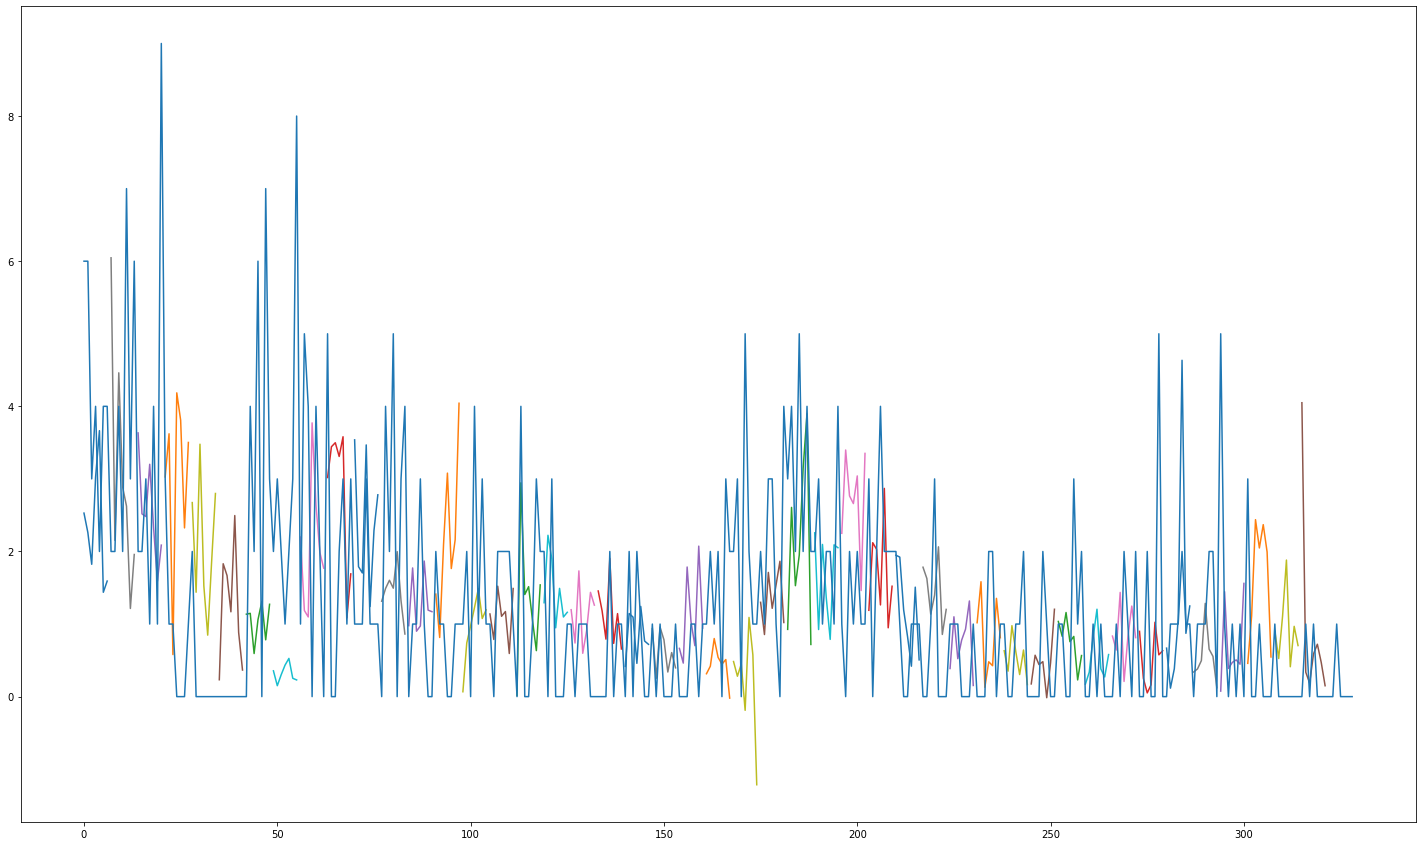

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'test':  np.random.rand(5)})
df2 = pd.DataFrame({'test':  np.random.rand(5)})


temp = X_test[day_temp*num:day_temp + day_temp*num].copy()
result = y_test[day_temp*num:day_temp + day_temp*num, 6:7].copy()
temp.shape

fig, ax = plt.subplots(figsize = (25, 15))

array = np.zeros(shape = (day_temp, day_temp))
array[:] = np.nan

for i in range(0, day_temp - 7, 7):
          predict = model.predict([temp[i]])

          array[i, i:i+7] = predict

# array = np.nan_to_num(array)

# array = np.sum(array, axis = 0)
sns.lineplot(data = array, ax = ax, color = 'red')

for row in range(array.shape[0]):
          sns.lineplot(data = array[row], ax = ax)

sns.lineplot(data = result, ax = ax)
ax.get_legend().remove()